In [1]:
import numpy as np
import pandas as pd

from scores import *
from align import *

In [2]:
! python -V

Python 3.7.7


In [3]:
np.__version__, pd.__version__

('1.21.5', '1.3.5')

# Example: Using bcftools to reshape the vcf first

bcftools is recommended here to process the vcf file first. Then, calculate the scores on the selected variants and individuals.

One exception is for a fast checking of the Minimac4 info and LooDosage file, which is usually at a small size. See test_plot.ipynb for an example.

Extract the vid and iid:

```sh
inpath=$1
outpath=$2
variants=overlapping.155297.idv
sample_file=overlapping.n993.iid

# print
bcftools view \
  --include ID==@$variants \
  --force-samples \
  -S $sample_file \
  -Ou $inpath | bcftools query \
  -f'%CHROM\t%POS\t%REF\t%ALT[\t%HDS]\n' > $outpath
```

Or if the vcf file is already on the same individuals:
```sh
bcftools query -f'%ID[\t%HDS]\n' $inpath > $outpath
```

# Example: Calculating scores from the imputed vcf

In this example, a dataset contained about 10k variants is used.

In real work, processing a large imputed dataset in python would require huge memory, and is not recommended.

In [4]:
loo_ds = "../../data/chr19.empiricalDose.vcf.gz"

true_gt0=pd.read_table(loo_ds,  
                    comment='#', header=None).iloc[:,9:]

#true_gt0 = loo_ds
gt = pd.concat([true_gt0.applymap(lambda x: x.split(":")[0].split("|")[0]), 
                    true_gt0.applymap(lambda x: x.split(":")[0].split("|")[1])], axis=1)

#lds = pd.read_table(fname1+i+fname2, comment='#', header=None).iloc[:,9:]
lds = pd.concat([true_gt0.applymap(lambda x: x.split(":")[1].split("|")[0]), 
                true_gt0.applymap(lambda x: x.split(":")[1].split("|")[1])], axis=1)

In [5]:
gt = gt.astype("int")

In [6]:
lds = lds.astype("float")

In [7]:
# sample dataset of true genotype
gt

,9,10,11,12,13,14,15,16,17,18,...,503,504,505,506,507,508,509,510,511,512
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,0,1,1,0
4,0,0,0,0,0,0,1,0,1,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9121,1,1,1,0,1,0,1,1,1,0,...,1,0,1,1,1,0,1,1,1,1
9122,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9123,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9124,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
# sample dataset of imputed dosage
lds

,9,10,11,12,13,14,15,16,17,18,...,503,504,505,506,507,508,509,510,511,512
0,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.001,0.000,...,0.000,0.000,0.000,0.000,0.039,0.274,0.000,0.000,0.001,0.000
1,0.245,0.186,0.271,0.046,0.153,0.058,0.906,0.053,0.890,0.111,...,0.009,0.309,0.200,0.688,0.220,0.057,0.164,0.010,0.013,0.046
2,0.025,0.007,0.014,0.003,0.011,0.001,0.062,0.005,0.000,0.007,...,0.991,0.011,0.004,0.000,0.993,0.316,0.010,0.476,0.023,0.003
3,0.039,0.032,0.041,0.004,0.095,0.016,0.060,0.011,0.002,0.021,...,0.999,0.045,0.003,0.007,0.259,0.614,0.026,0.940,0.971,0.004
4,0.274,0.032,0.099,0.006,0.083,0.267,0.642,0.010,0.829,0.043,...,0.002,0.039,0.978,0.906,0.018,0.002,0.080,0.056,0.000,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9121,0.992,0.993,0.992,0.047,1.000,0.722,0.972,0.990,0.905,0.000,...,0.841,0.168,0.983,0.993,0.908,0.369,0.977,1.000,0.987,0.992
9122,0.000,0.000,0.000,0.000,0.000,0.272,0.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.187,0.000,0.000,0.000,0.000
9123,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.003,0.000,...,0.000,0.000,0.000,0.000,0.004,0.000,0.000,1.000,0.000,0.000
9124,0.007,0.006,0.006,0.014,1.000,0.015,0.011,0.007,0.087,0.002,...,0.022,0.007,0.010,0.006,0.092,0.007,0.018,1.000,0.007,0.006


In [9]:
Rsq = rsq_minimac(hds=lds)

### Minimac Rsq ###


In [10]:
EmpR = cor_emp(gt, lds)

### correlation r ###
Now it is calculating the Pearson correlation


/Users/shi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/shi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [11]:
vid, Beta_imp, MARE = mare_beta_hap(loo_ds)

### MARE and Beta_imp from haploid data ###


In [12]:
df = pd.DataFrame()

df.index=vid
df["Rsq"] = Rsq
df["EmpR"] = EmpR
df["MARE"] = MARE
df["Beta_imp"] = Beta_imp

# if the corr < 0, corr^2 = 0
df["EmpRsq"] = np.where(df["EmpR"] >=0, df["EmpR"]**2, 0)

In [13]:
df

,Rsq,EmpR,MARE,Beta_imp,EmpRsq
chr19:247265:G:T,0.861844,0.878358,0.196920,0.711758,0.771513
chr19:267213:C:T,0.460535,0.738640,0.209272,0.636202,0.545588
chr19:277717:G:A,0.827485,0.890138,0.171831,0.876945,0.792346
chr19:280299:T:C,0.828413,0.927320,0.116043,0.861835,0.859922
chr19:288374:T:C,0.676695,0.920243,0.103638,0.791133,0.846847
...,...,...,...,...,...
chr19:58557986:T:C,0.749592,0.795787,0.274893,0.742177,0.633276
chr19:58564164:G:A,0.628674,0.736753,0.287427,0.492038,0.542805
chr19:58571001:C:T,0.989997,0.994893,0.010087,0.988846,0.989811
chr19:58576112:G:A,0.775407,0.971728,0.043225,0.958558,0.944256


<AxesSubplot:xlabel='EmpRsq', ylabel='Rsq'>

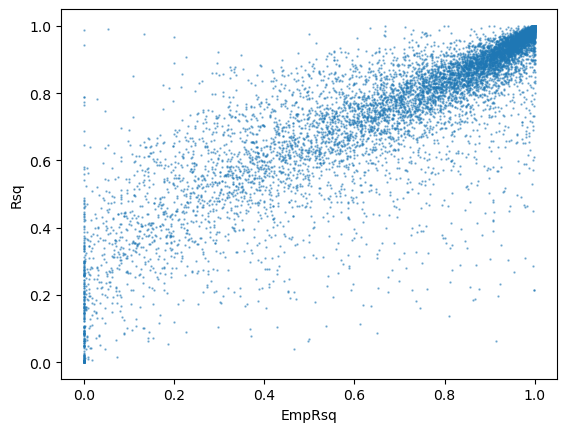

In [14]:
df.plot(kind="scatter", x="EmpRsq", y="Rsq", s=0.5, alpha=0.5)

Other score functions are also implemented, but generally, there is no need to calculate them.

Scores predicted from the imputed data areusually highly correlated; so did scores to compare with the true genotype.

Thus, the recommendation here is to calculate Rsq (as "predicted quality metric") and EmpRsq (as "true imputation accuracy") to filter the variants and benchmark different reference panels, etc; also use MARE and Beta_imp to check whether the imputation goes well.